In [33]:
import torch
from torch.utils.data import Subset,DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [24]:
batch_size = 64
num_classes = 10

In [25]:
train_set = datasets.MNIST('/content',train=True,download=True,transform=[transforms.ToTensor()])
test_set = datasets.MNIST('/content',train=False,download=True,transform=[transforms.ToTensor()])

### Preprocessing

In [26]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = invert(dataset_images)
    dataset_images = normalize(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

### Prepare the data

In [30]:
training_set = TensorDataset(torch.Tensor(train_images),torch.Tensor(train_labels))
testing_set = TensorDataset(torch.Tensor(train_images),torch.Tensor(train_labels))

subsets = {target: Subset(training_set,[i for i,(X,y) in enumerate(training_set) if y == target]) for _,target in train_set.class_to_idx.items()}
loaders = {target: DataLoader(subset) for target,subset in subsets.items()}

6131


IndexError: ignored

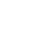

In [37]:
dataiter = iter(loaders[3])
images,labels = dataiter.next()
print(len(loaders[3]))

figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis("off")
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')